In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2 as cv
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

2022-09-27 10:18:45.236610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 10:18:45.236647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dev_qnn = qml.device('default.qubit', wires=range(8))

In [25]:
dev_qnn_lightning = qml.device('lightning.qubit', wires=range(8))

In [3]:
data = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [4]:
(x_train, y_train), (x_test, y_test) = data

In [5]:
print('Train')
for i in range(0, 10):
    print(f'{i} {np.sum(y_train == 0)}')

Train
0 5923
1 5923
2 5923
3 5923
4 5923
5 5923
6 5923
7 5923
8 5923
9 5923


In [6]:
print('Test')
for i in range(0, 10):
    print(f'{i} {np.sum(y_test == 0)}')

Test
0 980
1 980
2 980
3 980
4 980
5 980
6 980
7 980
8 980
9 980


In [7]:
count_train = 800
count_test = 200

In [8]:
prepare_train_dataset = np.array([x_train[y_train == i][:count_train] for i in range(0, 10)]).reshape((count_train*10,28,28))
prepare_train_target = np.array([y_train[y_train == i][:count_train] for i in range(0, 10)]).reshape((count_train*10, 1))
prepare_test_dataset = np.array([x_test[y_test == i][:count_test] for i in range(0, 10)]).reshape((count_test*10,28,28))
prepare_test_target = np.array([y_test[y_test == i][:count_test] for i in range(0, 10)]).reshape((count_test*10, 1))

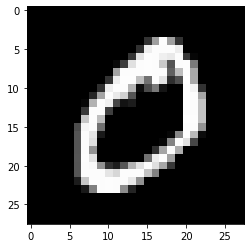

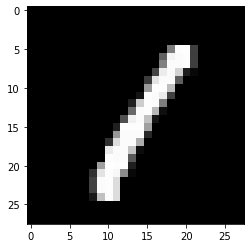

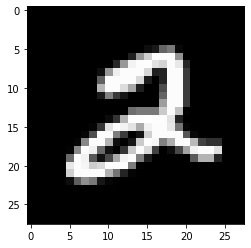

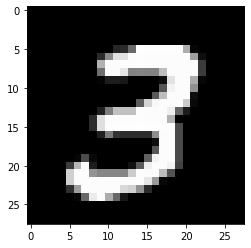

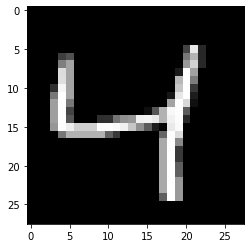

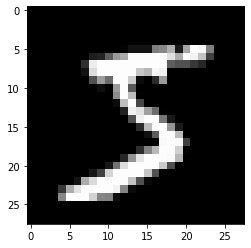

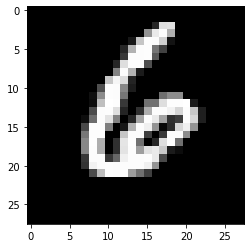

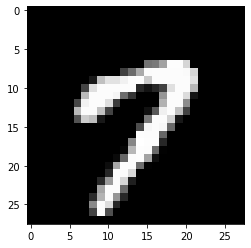

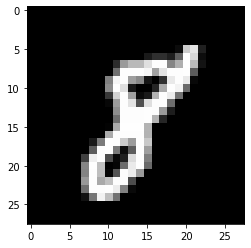

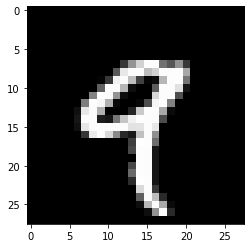

In [9]:
for i in range(0, count_train*10, count_train):
    plt.imshow(prepare_train_dataset[i], cmap='gray')
    plt.show()

In [10]:
train, t_train = shuffle(prepare_train_dataset, prepare_train_target, random_state=0)
test, t_test = shuffle(prepare_test_dataset, prepare_test_target, random_state=0)

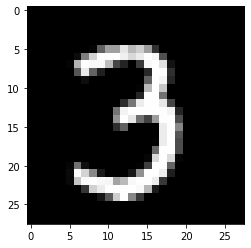

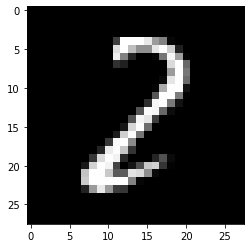

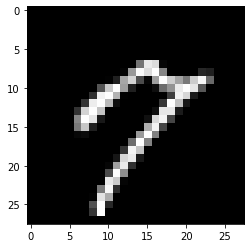

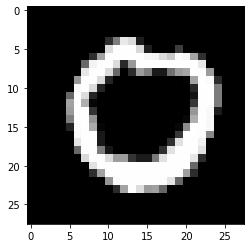

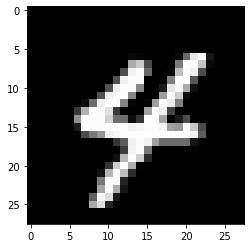

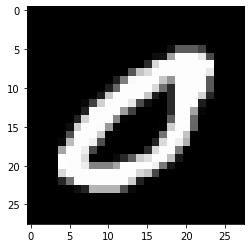

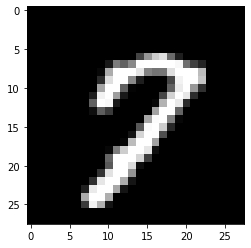

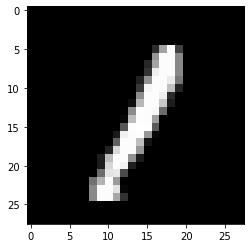

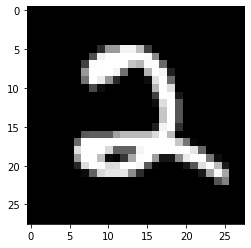

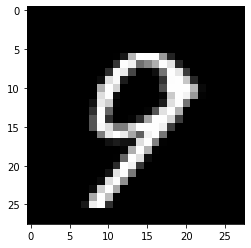

In [11]:
for i in range(0, 10):
    plt.imshow(train[i], cmap='gray')
    plt.show()

In [12]:
train_norm = []
for img in train:
    img_resize = cv.resize(img, (16, 16), interpolation=cv.INTER_LINEAR)
    img_norm = cv.normalize(img_resize, None, alpha=0,beta=1, norm_type=cv.NORM_MINMAX)
    img_reshape = img_norm.reshape((256,))
    norm = np.linalg.norm(img_reshape)
    train_norm.append(img_reshape / norm)
train_norm = np.array(train_norm)

In [13]:
test_norm = []
for img in test:
    img_resize = cv.resize(img, (16, 16), interpolation=cv.INTER_LINEAR)
    img_norm = cv.normalize(img_resize, None, alpha=0,beta=1, norm_type=cv.NORM_MINMAX)
    img_reshape = img_norm.reshape((256,))
    norm = np.linalg.norm(img_reshape)
    test_norm.append(img_reshape / norm)
test_norm = np.array(test_norm)

In [14]:
def amplitude_embedding(features, quants):
    qml.AmplitudeEmbedding(features=features, wires=quants)

In [15]:
def q_conv_circuit_1(theta, quants):
    qml.RY(theta[0], wires=quants[0])
    qml.RY(theta[1], wires=quants[1])
    qml.CNOT(wires=quants)

In [16]:
def q_pool_circuit(theta, quants):
    qml.CRZ(theta[0], wires=quants)
    qml.PauliX(wires=quants[0])
    qml.CRX(theta[1], wires=quants)

In [17]:
@qml.qnode(dev_qnn)
def qcnn(img, theta):
    qubits = range(8)
    amplitude_embedding(img, qubits)
    theta_i = 0
    # 1 layer
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 2), range(2, 9, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 2 layer
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(3, 8, 4), range(5, 10, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 3 layer
    q_conv_circuit_1(theta[theta_i:theta_i + 2], (3, 7))
    theta_i += 2
    q_pool_circuit(theta[theta_i:theta_i + 2], (3, 7))

    return qml.probs(wires=7)

In [105]:
new_target = [(np.pi / 40) + i * np.pi/20 for i in range(0,10)]

In [106]:
new_y_train = t_train.copy().astype(dtype=np.float64)
new_y_test = t_test.copy().astype(dtype=np.float64)
for i in range(0, 10):
    new_y_train[t_train == i] = new_target[i]
    new_y_test[t_test == i ] = new_target[i]

In [107]:
theta = np.zeros((40, ))

In [108]:
def predict(img, theta):
    probs = qcnn(img, theta)
    alpha, beta = np.sqrt(probs)
    return np.arccos(alpha)

In [109]:
%%time
predict(train_norm[0], theta)

CPU times: user 147 ms, sys: 3.54 ms, total: 151 ms
Wall time: 149 ms


tensor(0.74965344, requires_grad=True)

In [23]:
def cost(theta):
    N = train_norm.shape[0]
    phases = np.array([predict(img, theta) for img in train_norm])
    return 1/N * np.sum(np.power(phases - new_y_train, 2))

In [24]:
def accuracy_test(theta):
    N = test_norm.shape[0]
    phases = np.array([predict(img, theta) for img in test_norm])
    return 1/N * np.sum(np.power(phases - new_y_test, 2))

In [25]:
%%time
cost(theta)

CPU times: user 4min 36s, sys: 105 ms, total: 4min 36s
Wall time: 4min 38s


tensor(1656.72207807, requires_grad=True)

In [26]:
%%time
accuracy_test(theta)

CPU times: user 1min 5s, sys: 7.97 ms, total: 1min 5s
Wall time: 1min 5s


tensor(414.55022502, requires_grad=True)

In [27]:
opt = qml.GradientDescentOptimizer(0.01)

In [28]:
%%time
c_train = []
a_test = []
n_iter = 200
for i in range(n_iter):
    c_train.append(cost(theta))
    a_test.append(accuracy_test(theta))
    if i % 10 == 0:
        print(f'Iter: {i} Lost: {c_train[i]} Accuracy: {a_test[i]}')
    theta = opt.step(cost, theta)

Iter: 0 Lost: 1656.722078071874 Accuracy: 414.55022502382013
Iter: 10 Lost: 1634.9735640195252 Accuracy: 408.81531844160367
Iter: 20 Lost: 1633.3747393924173 Accuracy: 408.44236958997226
Iter: 30 Lost: 1632.7518412952077 Accuracy: 408.34264971228384
Iter: 40 Lost: 1632.1822500618866 Accuracy: 408.22298454202485
Iter: 50 Lost: 1631.5209882025954 Accuracy: 408.0294335939545
Iter: 60 Lost: 1630.6533202514154 Accuracy: 407.7391160191075
Iter: 70 Lost: 1630.0187234507946 Accuracy: 407.5210644626484
Iter: 80 Lost: 1629.7476850657417 Accuracy: 407.430049689148
Iter: 90 Lost: 1629.6292303907123 Accuracy: 407.39336406883007
Iter: 100 Lost: 1629.5617460660133 Accuracy: 407.3741145947018
Iter: 110 Lost: 1629.516045884638 Accuracy: 407.3615117583174
Iter: 120 Lost: 1629.4824569313487 Accuracy: 407.35220661562
Iter: 130 Lost: 1629.4565299480619 Accuracy: 407.3448609417896
Iter: 140 Lost: 1629.4356996121423 Accuracy: 407.3387945700414
Iter: 150 Lost: 1629.4183354978315 Accuracy: 407.33360586442456
I

In [29]:
print(f'Theta: {theta}')

Theta: [-1.75941248e-02 -1.16473169e-02 -5.08699135e-02  9.75296790e-02
  5.74587078e-02  1.23318958e-03  7.20796186e-03 -3.12010568e-02
 -1.68348920e+00  4.00163107e-02  1.97365269e-01 -6.00791304e-02
  1.56485808e+00  1.80525502e-02  5.87767953e-01 -7.66079102e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.87026868e-01  2.01034427e-01  3.91524619e-02  3.54503687e-02
  6.76565628e-03 -4.63200390e-02 -4.18118873e-03  6.41961533e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.05460598e-02 -7.11461533e-03  0.00000000e+00  0.00000000e+00]


In [32]:
decoding = np.array([[i * np.pi/20, (i + 1) * np.pi / 20] for i in range(0, 10)])
decoding

tensor([[0.        , 0.15707963],
        [0.15707963, 0.31415927],
        [0.31415927, 0.4712389 ],
        [0.4712389 , 0.62831853],
        [0.62831853, 0.78539816],
        [0.78539816, 0.9424778 ],
        [0.9424778 , 1.09955743],
        [1.09955743, 1.25663706],
        [1.25663706, 1.41371669],
        [1.41371669, 1.57079633]], requires_grad=True)

In [40]:
img = train_norm[0]
number = t_train[0]
predict_result = predict(img, theta)

In [37]:
number

tensor([3], dtype=uint8, requires_grad=True)

In [44]:
number_predict = None
for i in range(0, 10):
    if decoding[i, 0] < predict_result and predict_result < decoding[i, 1]:
        number_predict = i
        break

In [53]:
def get_result(dataset, theta):
    numbers_predict = []
    for img in dataset:
        predict_result = predict(img, theta)

        for i in range(0, 10):
            if decoding[i, 0] < predict_result and predict_result < decoding[i, 1]:
                numbers_predict.append(i)
                break

    return np.array(numbers_predict)

In [54]:
target_predict = get_result(train_norm, theta)

In [56]:
target_predict[100:200]

tensor([5, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 4, 5, 5, 4,
        5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5,
        4, 4, 5, 4, 5, 4, 4, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 4, 5,
        5, 5, 4, 4, 5, 4, 5, 5, 4, 5, 4, 5, 4, 5, 4, 4, 5, 5, 4, 5, 4, 4,
        5, 5, 4, 4, 4, 4, 5, 5, 4, 5, 5, 4], requires_grad=True)

In [57]:
accuracy_score(t_train, target_predict)

0.10375

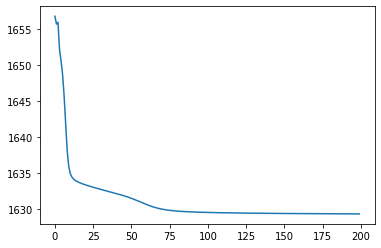

In [110]:
plt.plot(c_train)

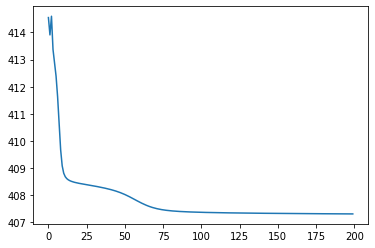

In [111]:
plt.plot(a_test)

# With Cross-Entropy (New way multilabel classification)

In [18]:
@qml.qnode(dev_qnn)
def qcnn(img, theta):
    qubits = range(8)
    amplitude_embedding(img, qubits)
    theta_i = 0
    # 1 layer
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 2), range(2, 9, 2)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(0, 8, 2), range(1, 8, 2)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 2 layer
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    for q_i, q_j in zip(range(3, 8, 4), range(5, 10, 4)):
        q_conv_circuit_1(theta[theta_i:theta_i + 2], (q_i, q_j % 8))
        theta_i += 2
    for q_i, q_j in zip(range(1, 8, 4), range(3, 8, 4)):
        q_pool_circuit(theta[theta_i:theta_i + 2], (q_i, q_j))
        theta_i += 2
    # 3 layer
    q_conv_circuit_1(theta[theta_i:theta_i + 2], (3, 7))
    theta_i += 2
    q_pool_circuit(theta[theta_i:theta_i + 2], (3, 7))

    return qml.probs(wires=(3,7))

In [ ]:
def log(probs):
    res = np
    for i in probs:
        for j in i:


In [19]:
def predict(img, theta):
    probs = qcnn(img, theta)
    return probs

In [76]:
def cross_entropy_train(theta):
    probs = np.array([predict(img, theta) for img in train0123])
    log_probs = qml.math.log(probs)
    print(f'LogProbs: {log_probs}')
    # print(f'NegInf: {log_probs[log_probs == -np.inf]}')
    # print(f'Inf: {log_probs[log_probs == np.inf]}')
    res = target_train0123 * log_probs
    print(f'Res: {res}')
    return -qml.math.sum(res)

In [39]:
def cross_entropy_test(theta):
    probs = np.array([predict(img, theta) for img in test0123])
    log_probs = np.nan_to_num(qml.math.toarray(qml.math.log(probs)), neginf=-19)

    return -qml.math.sum(target_test0123 * log_probs)

In [22]:
mask_train = (t_train == 0) | (t_train == 1) | (t_train == 2) | (t_train == 3)
train0123 = train_norm[mask_train[:,0]].copy()
y_train0123 = t_train[mask_train].copy()
mask_test = (t_test == 0) | (t_test == 1) | (t_test == 2) | (t_test == 3)
test0123 = test_norm[mask_test[:,0]].copy()
y_test0123 = t_test[mask_test].copy()

In [23]:
target_train0123 = np.zeros((y_train0123.shape[0], 4)).astype(dtype=np.int64)
for i, j in zip(range(0, y_train0123.shape[0]), y_train0123):
    target_train0123[i, j] = 1

target_test0123 = np.zeros((y_test0123.shape[0], 4)).astype(dtype=np.int64)
for i, j in zip(range(0, y_test0123.shape[0]), y_test0123):
    target_test0123[i, j] = 1

In [24]:
theta = np.zeros((40, ))

In [78]:
%%time
cross_entropy_train(theta)

LogProbs: [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
Res: [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
CPU times: user 2min 26s, sys: 71.9 ms, total: 2min 26s
Wall time: 2min 28s


tensor(nan, requires_grad=True)

In [33]:
%%time
cross_entropy_test(theta)

CPU times: user 32.2 s, sys: 78 ms, total: 32.3 s
Wall time: 32.5 s


tensor(2434.46060442, requires_grad=True)

In [34]:
opt = qml.GradientDescentOptimizer(0.01)

In [75]:
%%time
c_train = []
a_test = []
n_iter = 10
for i in range(n_iter):
    c_train.append(cross_entropy_train(theta))
    # a_test.append(cross_entropy_test(theta))
    # if i % 10 == 0:
    print(f'Iter: {i} Lost: {c_train[i]} Accuracy: {a_test[i]}')
    theta = opt.step(cross_entropy_train, theta)

LogProbs: [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
Res: [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]


IndexError: list index out of range

In [145]:
len(c_train)

1

In [146]:
theta

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [56]:
qcnn(train0123[0], theta).autograd

AttributeError: 'tensor' object has no attribute 'autograd'

In [36]:
probs = np.array([predict(img, theta) for img in train0123])
log_probs = qml.math.log(probs)
log_probs[log_probs == -np.inf] = 1.

In [37]:
log_probs = qml.math.log(probs)

In [40]:
mask = log_probs == -np.inf

In [181]:
mask.shape

(3200, 4)

In [182]:
log_probs[mask] = 0

In [71]:
log_probs[mask]

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, 

In [68]:
r = target_train0123 * log_probs

In [72]:
print(r[r == -np.inf])

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


In [51]:
-qml.math.sum(target_train0123 * log_probs).grad

AttributeError: 'tensor' object has no attribute 'grad'

In [50]:
print(log_probs.grad)

AttributeError: 'tensor' object has no attribute 'grad'

In [188]:
for i in mask:
    for j in i:
        print(j)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
qml.math.toarray

In [199]:
np.nan_to_num(np.log(probs), neginf=-19)

tensor([[-1.54044504, -1.13497993, -1.13497993, -1.94591015],
        [-1.70474809, -1.1451323 , -1.1451323 , -1.70474809],
        [-1.34992672, -1.34992672, -1.5040774 , -1.34992672],
        ...,
        [-1.70474809, -1.29928298, -1.09861229, -1.55059741],
        [-1.23214368, -1.38629436, -1.23214368, -1.79175947],
        [-1.43508453, -1.33977435, -1.33977435, -1.43508453]], requires_grad=True)

In [202]:
qml.math.sum(qml.math.log(probs) == -np.inf)

tensor(235, requires_grad=True)

In [ ]:
qml.qnn.cost

In [203]:
-np.inf * 0

nan

In [57]:
print(log_probs)

[[-1.54044504 -1.13497993 -1.13497993 -1.94591015]
 [-1.70474809 -1.1451323  -1.1451323  -1.70474809]
 [-1.34992672 -1.34992672 -1.5040774  -1.34992672]
 ...
 [-1.70474809 -1.29928298 -1.09861229 -1.55059741]
 [-1.23214368 -1.38629436 -1.23214368 -1.79175947]
 [-1.43508453 -1.33977435 -1.33977435 -1.43508453]]


In [60]:
import autograd.numpy as anp

In [63]:
print(anp.log(probs))

[[-1.54044504 -1.13497993 -1.13497993 -1.94591015]
 [-1.70474809 -1.1451323  -1.1451323  -1.70474809]
 [-1.34992672 -1.34992672 -1.5040774  -1.34992672]
 ...
 [-1.70474809 -1.29928298 -1.09861229 -1.55059741]
 [-1.23214368 -1.38629436 -1.23214368 -1.79175947]
 [-1.43508453 -1.33977435 -1.33977435 -1.43508453]]


In [66]:
dev_qnn.grad

AttributeError: 'DefaultQubit' object has no attribute 'grad'